This demonstration first creates a convolutional neural network (CNN) classifier of MNIST characters.  Then, a diffusion model is created and trained to produce fake character images.  Finally, the CNN classifier is used to classify diffusion model fake images.  The concept is similar to a generative adversarial neural network (GAN).

***It is recommended that this notebook be run on Google Colab or a computer with a dedicated GPU.  Running on only CPU may lead to absurdly long runtimes.

Please down load the EMNIST dataset (https://arxiv.org/pdf/1702.05373) to run this notebook.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, MaxPool2D, Flatten

2025-04-27 14:52:09.584932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745790729.737461   44975 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745790729.780308   44975 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check that GPU is active.

In [ ]:
 tf.config.list_physical_devices('GPU')

Importing CSV datasets.

In [ ]:
# train_folder = '/content/drive/MyDrive/ITP359/ITP359_FP/ITP359_FP_Data/P2/train.csv'
# test_folder = '/content/drive/MyDrive/ITP359/ITP359_FP/ITP359_FP_Data/P2/test.csv'
train_folder = "~/Desktop/FP/train.csv"
test_folder ="~/Desktop/FP/test.csv"
dfTrain = pd.read_csv(train_folder)
dfTest = pd.read_csv(test_folder)


# dfTrain = dfTrain.reshape()

In [ ]:
XTrain=dfTrain.drop(dfTrain.columns[0], axis=1)
yTrain=dfTrain.iloc[:,0]

XTest = dfTest.drop(dfTest.columns[0], axis=1)
yTest = dfTest.iloc[:,0]

# print(yTrain)
# print(XTrain.head())
# print(dfTrain.head())

Visualizing 100 digits/letters from training dataset.  Each image is labeled with the actual digit/label as well as the index corresponding to it.  Images are flipped from left to right and then rotated 90 degrees due to the nature of the dataset.

(112799, 28, 28, 1)


/tmp/ipykernel_44975/2853474945.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


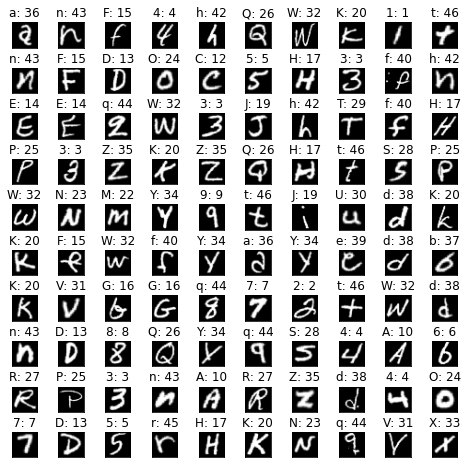

In [ ]:
XTrain = XTrain.to_numpy()
XTrain = XTrain.reshape(112799, 28,28,1)/255.
print(XTrain.shape)

XTest = XTest.to_numpy()
XTest = XTest.reshape(18799,28,28,1)/255.

# Dictionary assignment and replacement
num2Cat={0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"A",11:"B",12:"C",13:"D",14:"E",15:"F",16:"G",17:"H",18:"I",19:"J",20:"K",21:"L",22:"M",23:"N",24:"O",25:"P", 26: "Q", 27: "R", 28: "S", 29: "T", 30:"U", 31:"V",32:"W", 33:"X", 34:"Y", 35:"Z", 36:"a", 37:"b", 38:"d", 39:"e", 40:"f", 41:"g", 42:"h", 43:"n", 44:"q", 45:"r", 46:"t"}
yTrainCat = yTrain.replace(num2Cat)
# print(yTrainCat[1])

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
spec = gridspec.GridSpec(ncols=10, nrows=10, wspace=0.8, hspace=0.8)

for i in range(100):
  ax=fig.add_subplot(spec[i])
  ax.imshow(np.rot90(np.fliplr(XTrain[i])),cmap="gray")
  ax.set_title(yTrainCat[i]+ ": " + str(yTrain[i]))
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()

Convolutional neural network to classify the digits/letters. Softmax is used because the output is one of multiple categories (not binary classification).  Cross entropy loss function is also used, because this is a classification problem.   

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3),strides = (1,1), padding = "same", activation = "relu", input_shape=(28,28,1)))
model.add(Conv2D(64,(3,3),strides=(1,1), activation = "relu", padding="same"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), strides = (1,1), activation = "relu", padding="same"))
model.add(Conv2D(256, (3,3), strides = (1,1), activation="relu", padding = "same"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(47, activation = "softmax"))

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,631 (3.95 MB)

 Trainable params: 1,035,631 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

Training for 50 epochs.

In [ ]:
fit = model.fit(XTrain, yTrain, batch_size=64, epochs=50, validation_data=(XTest,yTest))

Epoch 1/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5072 - loss: 1.7234 - val_accuracy: 0.8597 - val_loss: 0.4033
Epoch 2/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8165 - loss: 0.5482 - val_accuracy: 0.8737 - val_loss: 0.3549
Epoch 3/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8432 - loss: 0.4588 - val_accuracy: 0.8777 - val_loss: 0.3386
Epoch 4/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8550 - loss: 0.4239 - val_accuracy: 0.8827 - val_loss: 0.3299
Epoch 5/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8626 - loss: 0.3947 - val_accuracy: 0.8851 - val_loss: 0.3272
Epoch 6/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8681 - loss: 0.3777 - val_accuracy: 0.8896 - val_loss: 0.3148
Epoch 7/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8718 - loss: 0.3610 - val_accuracy: 0.8890 - val_loss: 0.3164
Epoch 8/50
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8773 - loss: 0.3415 -

Plotting the loss curves for train and test datasets.

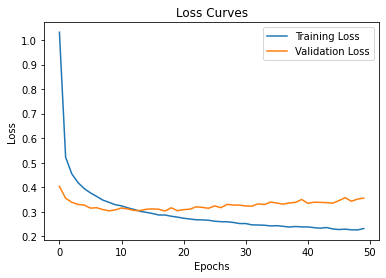

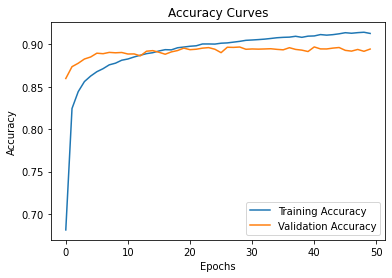

In [ ]:
history = fit.history

# Loss Curve
fig, ax = plt.subplots()
ax.plot(history["loss"], label = "Training Loss")
ax.plot(history["val_loss"], label="Validation Loss")
ax.set(title="Loss Curves", xlabel = "Epochs", ylabel="Loss")
ax.legend()

# Accuracy Curve
fig, ax = plt.subplots()
ax.plot(history["accuracy"], label="Training Accuracy")
ax.plot(history["val_accuracy"], label="Validation Accuracy")
ax.set(title="Accuracy Curves", xlabel = "Epochs", ylabel= "Accuracy")
ax.legend()

Displaying 25 test images and predicted labels

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipykernel_44975/3288873245.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


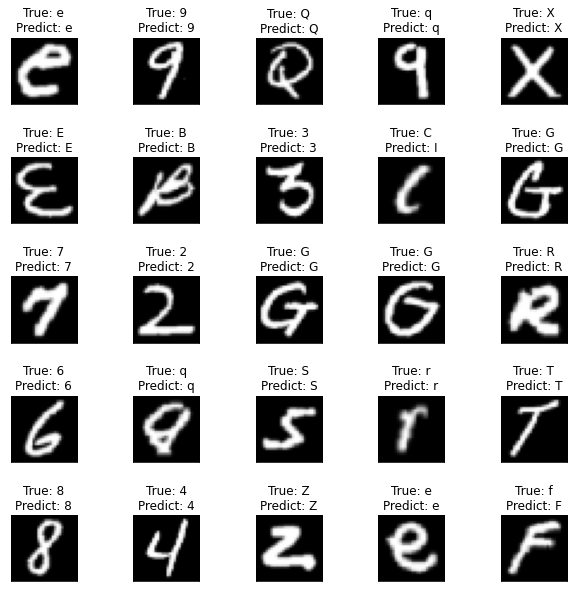

In [ ]:
pred = model.predict(XTest)
pred=np.argmax(pred,axis=1)
pred = pd.DataFrame(pred)
yTestCat = yTest.replace(num2Cat)
yTestPredCat = pred.replace(num2Cat)
yTestPredCat = yTestPredCat.to_numpy()
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
spec = gridspec.GridSpec(ncols=5, nrows=5, wspace=0.8, hspace=0.8)

for i in range(25):
  ax=fig.add_subplot(spec[i])
  ax.imshow(np.rot90(np.fliplr(XTest[i])),cmap="gray")
  ax.set_title("True: "+ str(yTestCat[i]) + "\nPredict: " + str(yTestPredCat[i][0]))
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

Now creating a denoising diffusion  Probabilistic Model (DDPM).

Process pixel values to be in range [-1 1].  Data is converted into a TensorFlow (TF) dataset and grouped into batches of 128 samples, which is the number of samples that will be passed in one training step.  Data is prefetched to load data in parallel with model execution.  AUTOTUNE allows TF to choose the optimal number of batches to prefetch for the fastest training speed.

In [ ]:
# Scale XTrain to be -1 to 1
XTrainDDPM = tf.cast(XTrain,tf.float32) * 2.-1.
# print(XTrainDDPM.shape())
# Make batches over which NN will be trained
XTrainDDPM = tf.data.Dataset.from_tensor_slices(XTrainDDPM).batch(128).prefetch(tf.data.AUTOTUNE)


A Time schedule is made to determine rate at which noise is added to images.

In [ ]:
# Create time schedule
T = 1000
beta_start = 1e-4
beta_end=0.02
beta=np.linspace(beta_start, beta_end, T, dtype=np.float32)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

In [ ]:
# Noise schedule
def get_noise_schedule(t):
  return beta[t], alpha[t], alpha_bar[t]

Convolution layers are defined in a function, which can be inserted in the DDPM UNet

In [ ]:
# Convolution block function
def conv_block(x, filters, kernel_size = 3):
  shortcut = x
  x = layers.Conv2D(filters, kernel_size, padding="same", activation = "relu")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, kernel_size, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  # If number of conv filters equals filters of another layer, add a shortcut
  x = layers.add([x, shortcut]) if shortcut.shape[-1] == filters else x
  x = layers.Activation("relu")(x)
  return x

DDPM UNet, which is a several layers of convolution blocks, maxpooling, and upsampling.  Skip connections are also added, which is common in diffusion models to improve performance.

In [ ]:
# Unet NN
def get_unet():
  # input has shape of 2 because time dimension was added to each pixel
  inputs = layers.Input(shape = (28,28,2))

  # Downsampling
  c1 = conv_block(inputs, 64)
  p1 = layers.MaxPool2D((2,2))(c1)

  # Further downsampling
  c2 = conv_block(p1, 128)
  p2 = layers.MaxPool2D((2,2))(c2)

  # bottleneck
  bn = conv_block(p2, 256)

  #Upsampling
  u1 = layers.UpSampling2D((2,2))(bn)

  #Add skip connection to upsampling layer
  u1 = layers.Concatenate()([u1,c2])
  c4 = conv_block(u1, 128)

  # More Upsampling
  u2 = layers.UpSampling2D((2,2))(c4)

  # Add skip connection to upsampling layer
  u2 = layers.Concatenate()([u2, c1])
  c5 = conv_block(u2, 64)

  # noise pred.  1 for each channel per pixel
  outputs = layers.Conv2D(1,1,padding="same")(c5)
  return tf.keras.Model(inputs, outputs)

In [ ]:
modelDDPM = get_unet()
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

DDPM is trained by first adding noise and then predicting the noise adding steps.

In [ ]:
def train_step(x):
  batch_size = tf.shape(x)[0]
  t = tf.random.uniform((batch_size,), 0, T, dtype = tf.int32)

  # Compute alpha bar at time step t
  alpha_bar_t = tf.gather(alpha_bar, t)

  # reshape alpha_bar_t to match the dimension of x
  alpha_bar_t = tf.reshape(alpha_bar_t, (-1,1,1,1))

  # add noise
  noise = tf.random.normal(tf.shape(x))
  x_t = tf.sqrt(alpha_bar_t) *x + tf.sqrt(1-alpha_bar_t)*noise

  # Embed time as an extra channel
  # scale t by diving by T
  t_scaled = tf.cast(t, tf.float32)/T
  t_broadcast = tf.ones_like(x[..., :1])*t_scaled[:, None, None, None]
  x_input = tf.concat([x_t, t_broadcast], axis = -1)

  # predict noise that was added
  with tf.GradientTape() as tape:
    noise_pred = modelDDPM(x_input, training = True)
    loss = tf.reduce_mean((noise-noise_pred)**2)

  grads = tape.gradient(loss, modelDDPM.trainable_variables)
  optimizer.apply_gradients(zip(grads, modelDDPM.trainable_variables))

  return loss

Training for 20 epochs and print loss for each epoch.

In [ ]:
# Train for 20 epochs
epochs = 20
for epoch in range(epochs):
  for step, batch_x in enumerate(XTrainDDPM):
    loss = train_step(batch_x)
  print(epoch+1, loss.numpy())

2025-04-27 15:07:04.850613: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1 0.07551611
2 0.051293448


2025-04-27 15:13:02.443192: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3 0.032702833
4 0.046804342
5 0.037830662
6 0.024802774


2025-04-27 15:24:56.022899: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


7 0.034081835
8 0.030722808
9 0.034774676
10 0.033924587
11 0.026263224
12 0.02872669
13 0.040055
14 0.040334817


2025-04-27 15:48:51.007890: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


15 0.038618743
16 0.067416914
17 0.027883021
18 0.027810289
19 0.041432
20 0.030323924


Generating and classifying 25 letters/digits.

In [ ]:
def sample(model, num_samples):
  # generate images which are pure noise
  x = tf.random.normal((num_samples, 28, 28, 1))

  # denoissing or reverse diffusion
  for t in reversed(range(T)):
    t_tensor = tf.ones((num_samples, ), dtype = tf.int32)*t
    t_scaled = tf.cast(t_tensor, tf.float32)/T

    t_broadcast = tf.ones_like(x[..., :1])* t_scaled[:, None, None, None]
    x_input = tf.concat([x, t_broadcast], axis = -1)

    # Add noise during denoising step
    z = tf.random.normal(tf.shape(x)) if t>0 else 0

    beta_t = beta[t]
    alpha_t= alpha[t]
    alpha_bar_t = alpha_bar[t]

    pred_noise = model(x_input, training = False)\

    # Predict image at time step t-1 by subtracting predicted noise from image at tme step t
    x = (1/tf.sqrt(alpha_t))*(x-(1-alpha_t)/tf.sqrt(1-alpha_bar_t) * pred_noise)

    if t>0:
      x = x+ tf.sqrt(beta_t)*z

  x = tf.clip_by_value((x+1.0)/2.0, 0.0, 1.0)
  return x

Run this block if using a virtual machine.  Otherwise, it may not be necessary.

In [ ]:
#For VDI (Virtual Machine at USC)
beta = tf.convert_to_tensor(beta, dtype = tf.float32)
alpha = tf.convert_to_tensor(alpha, dtype = tf.float32)
alpha_bar = tf.convert_to_tensor(alpha_bar, dtype = tf.float32)

Classify and display 25 fake images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


/tmp/ipykernel_44975/502420813.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


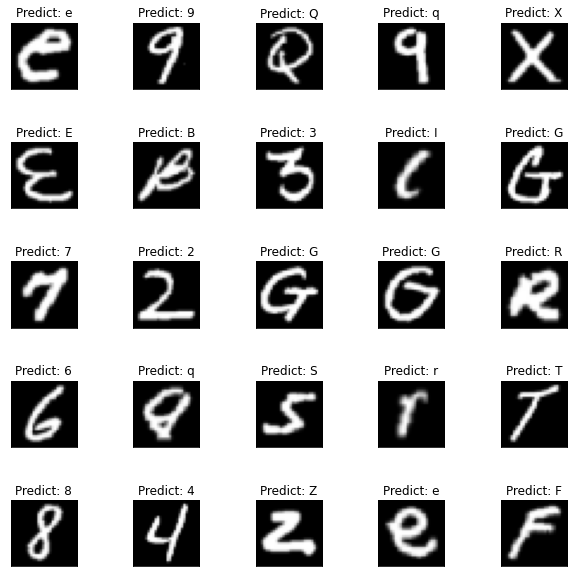

In [ ]:
samples = sample(modelDDPM, 25).numpy()

# Use Conv Classifier to predict what letter the DDPM produced samples are
predDDPM = model.predict(samples)
predDDPM = pd.DataFrame(pred)

predDDPM = predDDPM.replace(num2Cat)
predDDPM = predDDPM.to_numpy()

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
spec = gridspec.GridSpec(ncols=5, nrows=5, wspace=0.8, hspace=0.8)

for i in range(25):
  ax=fig.add_subplot(spec[i])
  ax.imshow(np.rot90(np.fliplr(XTest[i])),cmap="gray")
  ax.set_title("Predict: " + str(predDDPM[i][0]))
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()